# Initial Synchronization for 5G NR

This notebook walks through the processing a received 5G signal from preliminary analysis through recovery of timing information and decoding of the cell ID.

<a href="https://colab.research.google.com/github/bepepa/giti_lectures/blob/master/5G_synch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/giti_lectures/blob/main/5G_synch.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# signal processing toolbox
from scipy import signal

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## What is similar and what is different from LTE?

The basic approach to cell search is similar to how we analyzed the LTE signal. We will still proceed through:
* find symbol boundaries and initial estimate of frequency offset using the cyclic prefix (optional)
* find the primary synchronization signal (PSS) and extract part of the cell id
* estimate the frequency offset and locate symbol and slot boundaries from the location of the PSS
* find the secondary synchronization signal (SSS) and extract the remaining parts of the cell id

After locating the synchronization signals, we have access to the Master Information Block (MIB) which in turn points us towards the remaining system information in System Information Block 1 (SIB1).

Despite this similarity in processing, there are many clear differences that make processing of the 5G signal more challenging - most of these differences stem from the much greater flexibility inherent in the 5G standard.

Below are some of the key differences that we will encounter:


### 5G Numerology - flexible subcarrier spacing and wider bandwidth

Perhaps the most obvious difference to LTE is 5G's support for multiple subcarrier spacing options.

Recall that in LTE the subcarrier spacing is 15KHz and the maximum bandwidth is 20MHz. The maximum number of occupied subcarriers is 1332.

In 5G, five different subcarrier spacing options are provided. They are parameterized by the so-called *numerolgy* $\mu$ which takes on values between 0 and 4 (see TS 38.211, section 4.2).

The available subcarrier spacings are $\Delta f = 2^\mu \cdot 15$ KHz, i.e., 15KHz, 30KHz, 60KHz, 120KHz, and 240KHz. Note, however, that for the frequency range up to 6GHz (FR1), the maximum permitted subcarrier spacing is 60KHZ (see TS 38.104, section 5).

Also, in 5G up to 3300 subcarriers may be active.

As a result, 5G provides for more and wider bandwidth options than LTE. 5G channel bandwidth in FR1 may be up to 100MHz (TS 38.104, section 5.3.2). 

Permited bandwidths for speciified operating bands are given in TS 38.104, section 5.3.5.

### Frame Structure

The organization of OFDM symbols into frames, subframes, and slots differs from that used in LTE.

Recall that in LTE:
* Frames are 10ms in duration,
* Ten subframes constitute a frame, 
* Two slots make up a subframe, and
* seven OFDM symbols make up a slot (6 with extended cyclic prefix).

In 5G, fixed durations are not possible across numerologies since the duration of an OFDM symbol is inversely proportional to the subcarrier spacing.

According to TS 38.211, section 4.3, Frames are still 10ms long and contain 10 subframes; there is also the notion of a half-frame. 

In 5G, there are 14 OFDM symbols in a slot (12 with extended cyclic prefix). Hence, the number of slots per frame/subframe varies with numerology $\mu$. The number of slots per subframe is given by:
$$
    N_{slot}^{subframe,\mu} = 1 \cdot 2^\mu.
$$.



#### Side note

In LTE, the fundamental unit of time is $T_s = \frac{1}{2048 \cdot 15\text{KHz}}$, i.e., the sampling period for a 30.72MHz sampling rate.

In 5G, the fundamental unit of time is $T_c = \frac{1}{4096 \cdot 480\text{KHz}}$. This is the sampling rate required for OFDM with 4096 subcarriers and 480KHz subcarrier spacing ($f_s=$1966.08MHz).

The ratio $T_c/T_s$ is denoted $\kappa$ in the standard.

##### Example:

What sampling rate is required for a 100MHz bandwidth signal when subcarrier spacing is 30KHz ($\mu=1$)?

According to Table 5.3.2-1 in TS 38.104, for a 100MHz bandwidth and subcarrier spacing 30KHz, the signal occupies 273 resource blocks. Each resource block is comprised of $N_{SC}^{RB}=$ 12 subcarriers. Hence, the signal occupies 3276 subcarriers or 98.28MHz ($\approx$ 100MHz). 

To support 3276 subcarriers, a plausible choice for the FFT length is 4096. Hence, the required sampling rate is $4096 \cdot 30\text{KHz} = 122.88\text{MHz}$. 

#### Cyclic prefix

The cyclic prefixes are also scaled with the numerology - otherwise it wouldn't be possible to maintain 14 symbols per slot.

TS 38.211, section 5.3.1 states that the length of the cyclic prefix for the $l$-th symbol in a subframe in samples for a sampling rate of $fs = \frac{1}{T_c} = \frac{1}{4096 \cdot 480\text{KHz}}$ is
$$
N_{CP} = \begin{cases}
512 \cdot \kappa \cdot 2^{-\mu} & \text{extended cyclic prefix}\\
144 \cdot \kappa \cdot 2^{-\mu} + 16\kappa & \text{normal cyclic prefix, $l=0$ or $l=7\cdot 2^{\mu}$}\\
144 \cdot \kappa \cdot 2^{-\mu} & \text{normal cyclic prefix, other $l$}\\
\end{cases}
$$

For lower sampling rates $f_s$, these lengths are multiplied by $f_s \cdot T_c$. 

**For example**, when the signal is sampled at $f_s=30.72\text{MHz}$, then $f_s \cdot T_c = \frac{1}{64} = \frac{1}{\kappa}$. Thus, for $\mu=0$ (15KHz subcarrier spacing), the cyclic prefixes of the 0th and 7th symbol are 160 samples long; for all other symbols it is 144 samples. That's the same as in LTE.

When $\mu=1$ (30KHz subcarrier spacing), then the 0th symbol in each slot has a cyclic prefix of 80 samples and all other symbols have a cyclic prefix of 72 samples.

**Second example:** When $f_s=15.36\text{MHz}$, then $f_s \cdot T_c = \frac{1}{128} = \frac{1}{2\kappa}$. Thus, for $\mu=0$ (15KHz subcarrier spacing), the cyclic prefixes of the 0th and 7th symbol are 80 samples long; for all other symbols it is 72 samples. 

When $\mu=1$ (30KHz subcarrier spacing), then the 0th symbol in each slot has a cyclic prefix of 44 samples and all other symbols have a cyclic prefix of 36 samples.

### Definition of Synchronization Signals

Synchronization blocks may use either 15KHz or 30KHz subcarrier spacing in frequency range FR1. For most bands only one of the two options is permitted, but a few bands allow either subcarrier spacing.

The synchronization signals PSS and SSS are not defined in terms of Zadoff-Chu sequences. Both are derived from feedback shift register sequences.

The synchronization sequences are wider than in LTE. instead of 64 subcarriers, they occupy 127 subcarriers.

The two synchronization signals encode a larger number of cell ids. instead of 504 unique cell ids, 5G provides 1008.

The arrangement of synchronization elements is different. For example, in 5G the PSS precedes the SSS by two symbols.

To support beamforming even during connection establishment, the synchronization signals may be transmitted multiple times on different beams.

### Synchronization Signal is not (necessarily) centered on carrier

The arrangement and choice of frequency bands is much more flexible in 5G than in LTE. This flexibility incurs complexity in the form of additional parameters that must be either communicated (via MIB and SIB1) or discovered.

Specific to the synchronization signal, the center frequency of the synchronization block is not necessarily in the center of the band used to communicate (i.e., the carrier).

In 5G, a raster of frequencies has been defined that dictates where synchronization signals may occur. This raster is fairly coarse with a spacing of 1.2MHz. A UE may have to tune to multiple of these raster frequencies to find the synchronization signal.

From the frequency location of the synchronization signal coupled with information from the MIB and SIB1, the UE can figure out the location of the carrier.

![SSB Frequency](SSB_frequency.png)

### MIB Content and Coding

Owing to the greater flexibility, the MIB in 5G contains different and addtional parameters than LTE.

Additionally, the error-correction coding used for sending the MIB is differnt than in LTE. 5G uses a relatively new FEC code, called a *Polar Code*. LTE relies on a more classical convolutional code with repetition coding.

## Load data and perform preliminary analysis

In contrast to the LTE data, this signal has been synthesized. It still contains a frequency offset (1000 Hz) and the first sample is not on a symbol (slot/frame) boundary. The signal is corrupted by AWGN.

In [132]:
## load data
data_file = 'data/5g_sig_ssb.dat'
Fs = 15.36e6  # sampling rate

# read the entire data file and convert to complex samples
tmp = np.fromfile(data_file, dtype=np.int16)

scale = 2.0**(-15)

rx = scale * tmp[0::2] + 1j * scale * tmp[1::2]

### PSD

To assess the signal quality, we plot the power spectral density PSD.

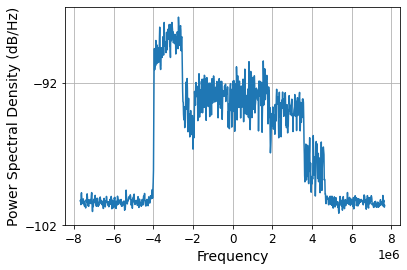

In [133]:
# First the PSD
Pxx, ff = plt.psd(rx[:], Fs=Fs, NFFT=1024)
# plt.xlim(-5e6, 5e6)
plt.show()

The signal occupies approximately 10MHz of bandwidth. Bandwidth occupancy is uneven - indicating a sparsely populated signal.

However, we cannot draw any conclusions about subcarrier spacing or other structural properties.

### Spectrogram

The spectrogram provides both a time and a frequency perspective on the signal.

First, the spectrogram of the entire signal is plotted.

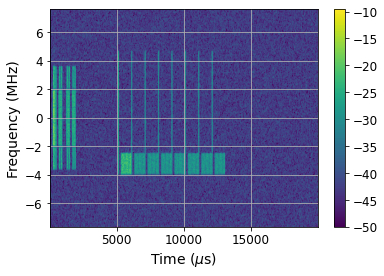

In [134]:
# Spectrogram of the entire signal
plt.specgram(rx[:], Fs=Fs/1e6, vmin=-50)
plt.grid()
plt.colorbar()
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Frequency (MHz)')
plt.show()

The spectrogram above spans about 20ms, i.e., 2 frames. We can discern repetitive structures at the rate of a subframe.

For a closer look at the signal, we zoom in on the first two milliseconds of the received signal; recall that a subframe is 1 ms long.

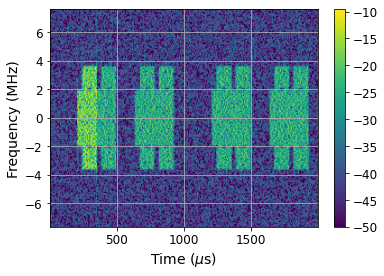

In [135]:
# Spectrogram of the first ms of received signal
plt.specgram(rx[:2*1024*15], Fs=Fs/1e6, vmin=-50)
plt.grid()
plt.colorbar()
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Frequency (MHz)')
plt.show()

The above portion of the spectrogram shows eight repetitions of what we will discover to be synchronization signal blocks (SSB).

The other features we observed in the full spectrogram are control (PDCH) and traffic (PSCH) channels; these carry the SIB1 information.

There are no user payload data in this capture.

## Exploitation of Cyclic Prefix 

As in LTE, we can exploit the correlation induced by the cyclic prefix to locate symbol boundaries and obtain an initial estimate of the freequency offset. 

The goal is to reduce the search space for the synchronization signal.

A complication arises from the support for different subcarrier spacings - multiple subcarrier spacings may even be in use simultaneously.

For the sample rate of this signal ($f_s=$ 15.36MHz), the number of samples in a symbol ($N_{FFT}$) and the length of the cyclic prefix ($N_{CP}$) differ by numerolgy $\mu$. 

For $\mu=0$ (15KHZ spacing): $N_{FFT} = \frac{f_s}{15\text{KHz}} = 1024$ and $N_{CP}=72$ (or 80 for symbols 0 and 7 of each slot).

For $\mu=1$ (30KHZ spacing): $N_{FFT} = \frac{f_s}{30\text{KHz}} = 512$ and $N_{CP}=36$ (or 44 for symbols 0 of each slot).

For $\mu=2$ (60KHZ spacing): $N_{FFT} = \frac{f_s}{60\text{KHz}} = 256$ and $N_{CP}=18$ (or 26 for symbols 0 of every other slot).

We will test the first two options.


### Cyclic Prefix Analysis for 15KHz SCS

For 15KHZ subcarrier spacing, the length of an OFDM symbol is 1024 samples at the given sample rate. The cyclic prefix is 72 samples long for most symbols.

We compute the correlation for one slot, which is also one subframe for this subcarrier spacing.

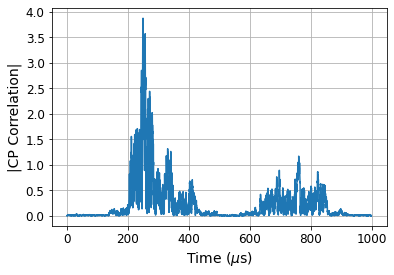

In [136]:
## cyclic prefix correlations for 15KHz SCS
N_FFT = 1024
N_CP = 72

# compute the length-N_CP autocorrelation at lag N_FFT over one subframe
N = 14*(N_FFT + N_CP)
corr = np.zeros(N, dtype=complex)

for n in range(N):
    seg1 = rx[n : n+N_CP]
    m = n + N_FFT
    seg2 = rx[m : m+N_CP]

    corr[n] = np.sum(seg2 * seg1.conj())

# plot the correlation
plt.plot(np.arange(N)/Fs*1e6, np.abs(corr))
plt.grid()

plt.xlabel('Time ($\mu$s)')
plt.ylabel('|CP Correlation|')

plt.show()

The correlation pattern does not reveal any strong and narrow correlation peak. It is unlikely that this signal uses 15KHz subcarrier spacing.

### Cyclic Prefix Analysis for 30KHz SCS

For 30KHZ subcarrier spacing, the length of an OFDM symbol is 512 samples at the given sample rate. The cyclic prefix is 36 samples long for most symbols.

We compute the correlation for two slots, which is equal to one subframe for this subcarrier spacing.

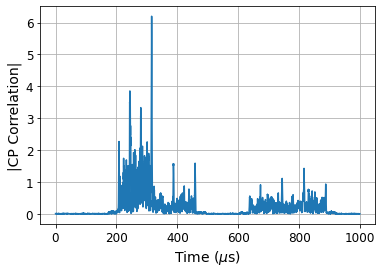

In [137]:
## cyclic prefix correlations for 30KHz SCS
N_FFT = 512
N_CP = 36

# compute the length-N_CP autocorrelation at lag N_FFT over one subframe
N = 28*(N_FFT + N_CP)
corr = np.zeros(N, dtype=complex)

for n in range(N):
    seg1 = rx[n : n+N_CP]
    m = n + N_FFT
    seg2 = rx[m : m+N_CP]

    corr[n] = np.sum(seg2 * seg1.conj())

# plot the correlation
plt.plot(np.arange(N)/Fs*1e6, np.abs(corr))
plt.grid()

plt.xlabel('Time ($\mu$s)')
plt.ylabel('|CP Correlation|')

plt.show()

The correlation shows multiple narrow peaks. 

This is a strong indication that the signal (at least the portion analyzed above) uses 30KHz subcarrier spacing.

However, we will not pursue this analysis further and will instead rely on the synchronization signal to determine signal timing and estimate frequency offset.

## The Synchronization Signal Block (SSB)

Synchronization signals are specified in TS 38.211, section 7.4.2.

Each SSB consists of three elements that span 4 OFDM symbols and occupy 240 contiguous subcarriers:
* Primary Synchronization Signal (PSS) is transmitted in the first (symbol 0) of the four symbols; 
* Secondary Synchronization Signal (SSS) is transmitted in the third (symbol 2) of the four symbols
* Physical Broadcast Channel (PBCH) is transmitted in symbols 1, 2 (on subcarriers not occupied by the PSS), and 3;

The location in time and frequency of the SSB is specified in TS 38.213, section 4.1.

![SSB Structure](https://1.bp.blogspot.com/-Os0SlT6sTbA/XZ49KIQ0UUI/AAAAAAAAn00/YVutkZL3mJQReIAXLOuLp4SkFvS7fFwjwCEwYBhgL/s1600/Time-Frequency_Structure_SSB.png)

### SSB Burst Sets

The SSB may be transmitted multiple times in close proximity, this is called an SSB burst set.

The goal is to support beamforming as early as possible. Hence, each of the SSBs in a burst set is transmitted using a different beam direction so that the UE can measure the most favorable beam direction.

SSB burst sets may contain up to eight SSBs in frequency range FR1; this is limited to four SSBS for frequencies below 3GHZ. 

There are five temporal patterns in which the SSBs may be arranged; three are applicable to FR1. For each operating band, the pattern to be used is prescribed by the standard (in Table 5.4.3.3-1 of TS 38.104). Therefore, the pattern in use for a given band is knowable.

Our signal uses the SSB block pattern 'Case B'. The five patterns are specified in TS 38.213, section 4.1. For  the 'Case B' pattern the standard says:

>Case B - 30 kHz SCS: the first symbols of the candidate SS/PBCH blocks have indexes $\{4, 8, 16, 20\}+ 28\cdot n$. For carrier frequencies smaller than or equal to 3 GHz, $n = 0$ . For carrier frequencies within FR1 larger than 3 GHz, $n=0,1$.

Here, index refers to the symbol number relative to the first symbol of the frst slot of a half-frame.

Our signal contains eight SSBs, sarting at symbols numbered 4, 8, 16, 20, 32, 36, 44, 48.

The fact that the 'Case B' pattern is used also confirms that the subcarrier spacing is 30KHz (at least for the SSBs).

### Frequency Location of SSBs

In LTE, the synchronization signal is always located at the center of a band. Hence, locating the synchronization signal also informs the center frequency. A raster of permitted center frequencies exists for each band and the UE may have to search for the center frequency. The raster has a granularity of 100KHz (TS 36.101, section 5.7.2). Given the relatively modest bandwidth of LTE, a search with this granularity is feasible.

The much more flexible arrangement of bands coupled with the much wider bandwidth supported by 5G, required a different approach.

In 5G a separate synchronization raster is defined that specifies the permitted frequencies at which a SSB may be centered. This raster is specified in terms of the *Global Synchronization Channel Number* (GSCN). Consecutive channel in the GSCN are separated by 1.2MHz which leads to a feasible search even for wide bandwidths. GSCN applicable for each band are specified in Table 5.4.3.3-1 of TS 38.104.

Note that the other (non-SSB) parts of the signal are not restricted to the GSCN raster. They can be placed with much finer granularity. As a consequence, it **cannot** be assumed that the SSB is in the center of the band. The offset between the SSB and the rest of the signal is conveyed via the MIB and SIB1.



## Locate the Primary Synchronization Signal (PSS)

The PSS is located in the first symbom of an synchronization signal burst (SSB). 

It consists of one of three possible frequency domain patterns - the choice of patterns is determined by a part of the cell id.

### PSS Construction 

The PSS is specified in TS 38.211, section 7.4.2.2:

> The sequence $d_{PSS}(n)$ for the primary synchronization signal is defined by 
$$
d_{PSS}(n) = 1 − 2 x(m )
$$
$$
m = (n + 43 \cdot N_{ID}^{(2)} ) \mod 127
$$
$$
0 \leq n < 127
$$
> where
$$
x(i + 7)= (x(i + 4)+ x(i)) \mod 2
$$
> and 
$$
\left[ x(6), x(5), x(4), x(3), x(2), x(1), x(0)\right]= [1, 1, 1, 0, 1, 1, 0]
$$

Above $N_{ID}^{(2)}$ is part of the cell ID and takes on values in $\{0,1,2\}$.

The 127 BPSK symbols of the PSS appear on subcarriers 56 through 182 of the 240 subcarriers that constitute a SSB.

We first define a function to generate the PSS sequence.

In [138]:
def PSS_seq(N_id_2):
    "Generate PSS frequency domain sequence for given N_id_2"
    x = np.zeros(127, dtype=np.uint8)
    # initial conditions
    x[:7] = np.array([0,1,1,0,1,1,1])

    # recurse the LFSR
    for i in range(120):
        x[i+7] = x[i+4] ^ x[i]

    # apply cyclic shift using np.roll and convert to BPSK
    return 1. - 2. * np.roll(x, -43*N_id_2)

To correlate in the time-domain, we need to transform this signal into the time-domain.

In [139]:
def PSS_sig(N_id_2, N_FFT):
    "Generate PSS time domain signal"
    d = PSS_seq(N_id_2)

    # we construct the signal so that the subcarriers in the center are occupied
    # that implies that N_FFT - 240 subcarriers on the outsides are left empty
    N_guard = (N_FFT - 240) // 2

    # construct FD signal, fill 127 center carriers
    S = np.zeros(N_FFT, dtype=complex)
    S[N_guard + 56 : N_guard + 183] = d

    return np.fft.ifft(np.fft.ifftshift(S))

### Correlating the PSS against the received signal

We will make the simplifying (and true) assumption that the center frequency of the signal is on the GSCN synchronization raster. That implies that we can correlate agains the received signal directly without first shifting frequency.

If no correlation is found, we should frequency shift the received signal by (plus or minus) 1.2MHz to shift the next GSCN to the center of the band.

Below, we correlate each of the three candidate signals against the entire received signal. That is not computationally efficient and can be improved, e.g., by sttopping the correlation when a large peak has been found or by leveraging estimates of symbol boundaries obtained via analysis of the cyclic prefix.

In [156]:
## Correlate the received signal against each of the three PSS sequences
N_FFT = 512

N_max = len(rx) - N_FFT
corr = np.zeros((N_max, 3), dtype=complex)

# this is where frequency shifting to another GSCN frequency  happen
shift = 0 # set to +/- 1, 2
rx_shifted = rx * np.exp(-2j * np.pi * shift * np.arange(len(rx)) * 1.2e6 / Fs)

# pre-compute the PSS signals
pss_sigs = np.zeros((3, N_FFT), dtype=complex)
for m in range(3):
    pss_sigs[m, :] = PSS_sig(m, N_FFT)

for n in range(N_max):
    seg = rx_shifted[n : n+N_FFT]

    for m in range(3):
        corr[n, m] = np.sum(seg * np.conj(pss_sigs[m, :]))



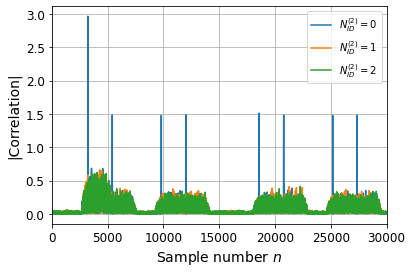

In [157]:
# plot the three correlations
plt.plot(np.abs(corr))
plt.grid()
plt.xlim(0, 30000)
plt.legend(['$N_{ID}^{(2)}=0$', '$N_{ID}^{(2)}=1$', '$N_{ID}^{(2)}=2$'])
plt.xlabel('Sample number $n$')
plt.ylabel('|Correlation|')
plt.show()

### Extracting $N_{ID}^{(2)}$ and location of PSS

From the correlation peaks, we can now easily determine the $N_{ID}^{(2)}$ and location of the PSS.

Note, however, that we cannot say with confidence which of the (up to) eight SSBs we just located. Hence, we still don't know precisely where the slot boundary is.

In [158]:
## determine the timing offset and N_id_2
max_corrs = np.zeros(3)
arg_max_corrs = np.zeros(3, dtype=int)

for m in range(3):
    arg_max_corrs[m] = np.argmax(np.abs(corr[:, m]))
    max_corrs[m] = np.abs(corr[arg_max_corrs[m], m])

N_id_2 = np.argmax(max_corrs)
loc_pss = arg_max_corrs[N_id_2]

print("N_id_2 = {:d}".format(N_id_2))
print("strongest PSS starts at sample: {:d} (after cyclic prefix)".format(loc_pss))

N_id_2 = 0
strongest PSS starts at sample: 3236 (after cyclic prefix)


### Estimation of Frequency Offset

Having located the PSS, we can now use it to estimate the frequency offset.

To do so, we measure the phase difference between the frist and second half of the PSS.

In [159]:
## measure the frequency offset
# first locate the segment of the received signal that contains the PSS
seg = rx_shifted[loc_pss : loc_pss + N_FFT]

# multiply with the conjugate of the appropraite PSS sequence
pss_seg = seg * np.conj(pss_sigs[N_id_2, :])

# compute sums over first and second half of this product
s_first = np.sum(pss_seg[:N_FFT // 2])
s_second = np.sum(pss_seg[N_FFT // 2 :])

# then measure the phase difference
d_phi = np.angle(s_second * np.conj(s_first))

# translate into a frequency offset
df = d_phi / (2*np.pi * N_FFT/2) * Fs

print("Estimated Frequency Offset {:6.1f}Hz (True: 1000Hz)".format(df)) 

Estimated Frequency Offset 1115.1Hz (True: 1000Hz)


### Estimation of Frequency Response

Finally, in preparation for processing the secondary synchronization signal (SSS), we estimate the frequency response over the subcarriers occupied by the PSS and SSS.

To estimate the frequency response for these subcarriers, the samples containing the PSS are first frequency corrected and then transformed into the frequency domain.

The frequency response estimate is obtained by dividing by (or multiplying by conjugate of) the PSS frequency domain sequence.

In [160]:
## estimate the frequency response for PSS/SSS subcarriers
# we begin by extracting the entire SS/PPCH block consisting of 4 OFDM symbols (including the CP of the PSS)
N_CP = 36
N_FFT = 512
N_guard = (N_FFT - 240) // 2

SSB_samples = rx_shifted[loc_pss - N_CP : loc_pss - N_CP + 4 * (N_FFT + N_CP)]

# apply frequency correction to this block; this ensures phase continuity
SSB_samples = SSB_samples * np.exp(-2j * np.pi * 1000 * np.arange(len(SSB_samples)) / Fs)

# transform the four symbols to the frequency domain
SSB_freq = np.zeros((4, 240), dtype=complex)
for n in range(4):
    first = N_CP + n*(N_CP + N_FFT)
    last = first + N_FFT
    seg = SSB_samples[first : last]
    seg_fd = np.fft.fftshift(np.fft.fft(seg, N_FFT))
    SSB_freq[n, :] = seg_fd[N_guard : -N_guard]

# the PSS is in the center of the first symbol of SSB_freq
PSS_rx = SSB_freq[0, 56:183]

# # estimate the frequency response
H_est_pss = PSS_rx * np.conj(PSS_seq(N_id_2))

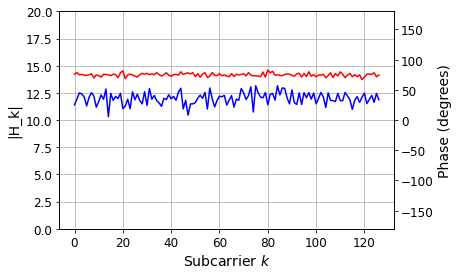

In [146]:
## plot the magnitude and phase of the channel estimate from PSS
fig, ax = plt.subplots()
# magnitude
ax.plot(np.arange(127), np.abs(H_est_pss), 'b-', label='Magnitude')
plt.grid()

ax.set_xlabel('Subcarrier $k$')
ax.set_ylabel('|H_k|')
ax.set_ylim(0, 20)

# phase
ax2 = ax.twinx()
ax2.plot(np.arange(127), np.angle(H_est_pss) * 180/np.pi, 'r-', label="Phase")
ax2.set_ylabel('Phase (degrees)')
ax2.set_ylim(-180, 180)

plt.show()

This channel is very benign. There is no indication of distortion due to multi-path. Hence, equaliztion is not really necessary.

## Processing the Secondary Synchronization Signal (SSS)

From the secondary synchronization signal we obtain the remainder of the cell ID. 

The SSS occupies the same subcarriers as the PSS and is located two symbols behind the PSS. Since we have located the PSS and time and frequency, we can easily find the samples of the SSS.

We will process the SSS in the frequency domain.

Recall that we have already frequency corrected and transformed the entire SS/PBCH block (variable `SSB_freq`) so that we only need to:
* extract the second symbol from `SSB_freq`
* pull out the center 127 subcarriers
* perform frequency domain equalization using the channel estimates from PSS

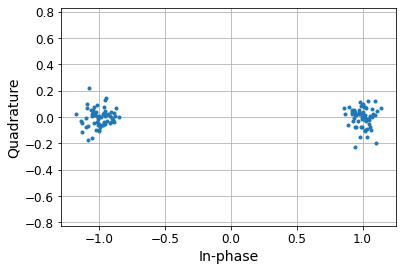

In [163]:
## Pre-process the SSS
# extract the appropriate subcarriers from SSB_freq
SSS_rx = SSB_freq[2, 56:183]

# equalize
SSS_rx = SSS_rx / H_est_pss

# plot the received constellation; this should be a clean BPSK
plt.plot(np.real(SSS_rx), np.imag(SSS_rx), '.')
plt.grid()
plt.axis('equal')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')

plt.show()

### Construction of Secondary Synchronization Sequence (SSS)

We have a clean version of the 127 subcarriers of the SSS. 

There are 336 possible SSS sequences that encode the SSS. These sequence are again constructed from *Feedback Shift Register Sequences* as specified in section 7.4.2.3 of TS 38.211.

The function below generates all SSS sequences for given $N_{ID}^{(2)}$.

In [166]:
def SSS_seq(N_id_2):
    "Generate all 355 SSS sequences for a given N_id_2"
    # two shift register sequences x0 and x1
    x0 = np.zeros(127, dtype=np.uint8)
    x1 = np.zeros(127, dtype=np.uint8)

    x0[0] = 1
    x1[0] = 1

    for i in range(120):
        x0[i+7] = x0[i+4] ^ x0[i]
        x1[i+7] = x1[i+1] ^ x1[i]

    # generate SSS sequences from x0 and x1
    d_sss = np.zeros((336, 127))
    for N_id_1 in range(336):
        m0 = 15 * (N_id_1 // 112) + 5*N_id_2
        m1 = N_id_1 % 112

        d_sss[N_id_1] = (1. - 2.*np.roll(x0, -m0)) * (1. - 2.*np.roll(x1, -m1))

    return d_sss


### Identifying the Received SSS

To determine which of the 336 possible sequences is contained in the received signal, we correlate the cleaned frequency domain signal for the SSS against all possible sequences. The sequence that yields the highest correlation is most likely to have been transmited.

From the index of the sequence with the highst correlation, we can determine $N_{ID}^{(1)}$ from which the cell ID can be computed.

In [171]:
## corelate agains all possible sequences
corr = np.zeros(336)

# pre-compute SSS sequences
d_sss = SSS_seq(N_id_2)

for n in range(336):
    corr[n] = np.abs(np.sum(SSS_rx * d_sss[n, :]))

N_id_1 = np.argmax(corr)

print("Highest correlation occurs for N_id_1 = {:d}".format(N_id_1))
print("Cell id: {:d}".format(3*N_id_1 + N_id_2))

Highest correlation occurs for N_id_1 = 34
Cell id: 102


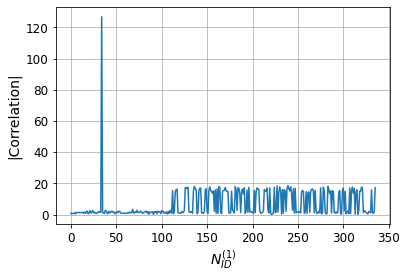

In [170]:
## plot the correlation
plt.plot(corr)
plt.grid()
plt.xlabel('$N_{ID}^{(1)}$')
plt.ylabel('|Correlation|')

plt.show()


A clear, strong correlation peak occurs for $N_{ID}^{(1)}=34$.

## What is next?

The next task is processing the remainder of the SS/PBCH block. Specifically:

1. **Finalize the timing Estimation:** Because there are (possibly) multiple SSBs, we cannot determine the precise slot boundaries. The information $\bar{i}_{SSB}$ which of the up to eight SSBs we found is encoded in the demodulation reference sequence (DMRS) in the PBCH. A search over the eight possibilities resolves the ambiguity and identifies slot and even half-frame boundaries.
2. **Extract the DMRS for the PBCH:** The PBCH contains 576 QPSK symbols that "wrap around" the PSS and SSS. Of these, 144 symbols are DMRS symbols that are used to estimate the channel over the entire bandwidth of the SSB. This channel estimation is used to equalize the data symbols in the PBCH. This is complicated by the fact that location and contents of the DMRS depends on which of the eight SSB we observed.
3. **Extract and equalize the data symbols in the PBCH:** The PBCH carries 432 information symbols; these contain 864 scrabled bits that are QPSK modulated. The symbols must be equalized, demodulated, and descrambled.
4. **Decoding of PBCH payload:** The 864 bits in the PBCH are heavily coded. A novel error-corecting code (Polar code) and a 24-bit CRC is used to protect the content. If successful, the decoding process yields 24 bits that constitute the MIB.
![PBCH Decoding Process](https://www.sharetechnote.com/html/5G/image/NR_PBCH_01.png)
5. **Locate and recover SIB1:** The MIB contains enough information to find the SIB1. This is a two-step process: (1) the MIB actually conveys information about acess to a control channel (PDCCH). (2) The control channel conveys when and where the SIB1 is transmitted on a PSCH.

### What's in the MIB?

The MIB is specified in terms of it's ASN-1 definition:

```
MIB ::= SEQUENCE {
    systemFrameNumber                   BIT STRING (SIZE (6)), => 6 bits
    subCarrierSpacingCommon             ENUMERATED {scs15or60, scs30or120}, => 1 bit
    ssb-SubcarrierOffset                INTEGER (0..15), => 4 bits
    dmrs-TypeA-Position                 ENUMERATED {pos2, pos3},  => 1 bit
    pdcch-ConfigSIB1                    INTEGER (0..255), => 8 bits
    cellBarred                          ENUMERATED {barred, notBarred},  => 1 bit
    intraFreqReselection                ENUMERATED {allowed, notAllowed}, => 1 bit
    spare                               BIT STRING (SIZE (1)) => 1 bit
}
```

Of particular interest for locating the SIB are the fields:
* `subCarrierSpacingCommon`: indicates the subcarrier spacing used for SIB1. 
* `ssb-SubcarrierOffset`:provides the frequency offset in subcarriers between the SSB and the resource grid used by the carrier (indicates a resource block boundary). With this information, subsequent information can be expressed more compactly in resource blocks instead of subcarriers. (marked `kSSB` in figure below.)
* `pdcch-ConfigSIB1`: provides a pair of indices into lookup tables (in TS 38.213that define the **CORESET** and the **Search Space** used on the PDCCH. With this information, the UE can process control messages on the PDCCH. This includes the frequency offset to the PDCCH (marked `Offset Type0Coreset` in the figure below.)

![Frequency Relationships between SSB and PDCCH](SSB_frequency.png)

### What's in SIB1

Here is an abbreviated version of the ASN-1 for SIB1:

```
SIB1 ::= SEQUENCE {
   cellAccessRelatedInfo::= SEQUENCE {
    plmn-IdentityList                PLMN-IdentityInfoList,
    cellReservedForOtherUse          ENUMERATED {true} OPTIONAL, -- Need R
    ...
}
 ,
   ...
   servingCellConfigCommon ::= SEQUENCE {
      downlinkConfigCommon ::= SEQUENCE {
         frequencyInfoDL
            FreqBandIndicatorNR
            offsetToPointA INTEGER (0..2199)
            scs-SpecificCarrierList
               offsetToCarrier INTEGER (0..2199)
               subcarrierSpacing ::= ENUMERATED {kHz15, kHz30, kHz60, kHz120, kHz240, spare3, spare2, spare1}
               carrierBandwidth INTEGER ::= 1..275

         initialDownlinkBWP BWP-DownlinkCommon
            locationAndBandwidth INTEGER (0..37949) // RIV
            subcarrierSpacing ::= ENUMERATED {kHz15, kHz30, kHz60, kHz120, kHz240, spare3, spare2, spare1}            
         ...
         }
      uplinkConfigCommon ::= SEQUENCE {
         frequencyInfoUL
            FreqBandIndicatorNR
            absoluteFrequencyPointA ::= INTEGER (0..3279165)
            scs-SpecificCarrierList
               offsetToCarrier INTEGER (0..2199)
               subcarrierSpacing ::= ENUMERATED {kHz15, kHz30, kHz60, kHz120, kHz240, spare3, spare2, spare1}
               carrierBandwidth INTEGER ::= 1..275

         initialUplinkBWP BWP-UplinkCommon
            locationAndBandwidth INTEGER (0..37949) // RIV
            subcarrierSpacing ::= ENUMERATED {kHz15, kHz30, kHz60, kHz120, kHz240, spare3, spare2, spare1}            
         ...
         }
      ...
      }
   ...
   }
  
```

Of particular interest are:
* `offsetToPointA`: provides an absolute frequency reference for the system.
* `offsetToCarrier` and `carrierBandwidth`: may be repeated for different subcarrier spacings. indicate band-edge and bandwidth of carrier.
* `plmn-IdentityList`: indicates the operator